In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [2]:
raw = pd.read_csv('./filtered_helpfulness.csv')

### Flatten data

In [3]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [4]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']

In [5]:
# include spammers:
include = True
if not include:
    spammers = ['A3A0RP6IUR41PP']
    melted = melted[~melted.WorkerId.isin(spammers)].copy()

In [6]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,5):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [7]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,5) ], [])

In [8]:
flat.head(1)

,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,WorkerId2,answer2,WorkerId3,answer3,WorkerId4,answer4
0,30OITAWPBQ4YB0SP96MMQOOHX7T9HP,W,Who the fuck demands their partner lose weight...,You have to ask?,A12JKMVUW5HNKO,Response provides some information to the ques...,AA5ZDXAA2DLY1,Response provides no information to the questi...,A1ET2J1PIP0RGO,Response provides no information to the questi...,A32W24TWSWXW,Response provides no information to the questi...,AFIK3VBMMX6G6,Response provides no information to the questi...


### Collapse labels

In [9]:
flat.answer0.unique()

array(['Response provides some information to the question',
       'Response satisfactorily answers the question',
       'Response provides no information to the question at all',
       'Response does not make sense'], dtype=object)

In [10]:
def scale(x):
    if 'Response satisfactorily' in x:
        return 3
    elif 'provides some' in x:
        return 2
    elif 'does not make sense' in x:
        return 0
    elif 'provides no' in x:
        return 1

In [11]:
melted['scale'] = melted.answer.apply(scale)

### Means analysis

In [12]:
melted.groupby('gender').count()

,HITId,q_idx,WorkerId,query,response,answer,scale
gender,,,,,,,
M,355,355,355,355,355,355,355
W,245,245,245,245,245,245,245


In [13]:
# variance
melted['scale'].std()

1.0648373991835822

In [14]:
# standard error
melted['scale'].std() / np.sqrt(np.sum(melted.gender == 'W'))

0.06802996598738768

In [15]:
melted.groupby('gender').mean()

,q_idx,scale
gender,,
M,6.563380,1.974648
W,6.408163,1.946939


<AxesSubplot:xlabel='gender', ylabel='scale'>

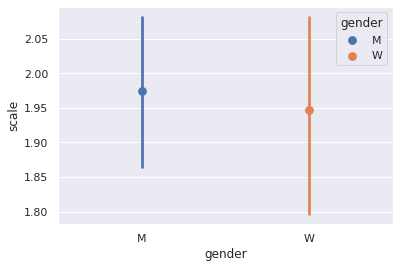

In [16]:
sns.pointplot(x='gender', y='scale', data=melted, hue='gender', conf=68)